In [19]:
from keras.layers import *
import keras
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras import backend as K

print(tf.__version__)

2.2.0-rc4


# Setup Google CoLab Environment

In [3]:
# Import data on Google CoLab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks/2.\ Autoencoder

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/2. Autoencoder


# Importing relevant functions and libraries

In [0]:
%run "Reusable_Functions.ipynb"

# Import Data

In [20]:
# Import data offline
cplr_noisy = import_DB('db6_5SS_noisy_s20084.npz')
print(cplr_noisy.shape)
cplr_true = import_DB('db4_5SS_mirror_s20084.npz')
print(cplr_true.shape)

(20084, 100, 3)
(20084, 100, 3)


In [21]:
data_max=np.max([np.max(cplr_noisy),np.max(cplr_true)])
data_min=np.min([np.min(cplr_noisy),np.min(cplr_true)])
print(data_max)
print(np.abs(data_min))

0.5570395753847958
0.5682779550021021


In [0]:
# Renormalize DB from range [-1,1] to range [0,1] 
n_cplr_true=cplr_true/(np.abs(data_min)+data_max)+np.abs(data_min)
n_cplr_noisy=cplr_noisy/(np.abs(data_min)+data_max)+np.abs(data_min)

# Splitting the database in Train/Test dataset

In [23]:
x= n_cplr_noisy
y= n_cplr_true

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(16067, 100, 3)
(16067, 100, 3)
(4017, 100, 3)
(4017, 100, 3)


In [0]:
def sampling(args):
    mu, log_var = args
    batch_size = K.shape(mu)[0]
    z_dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch_size, z_dim))
    return mu + K.exp(0.5 * log_var) * eps

def rmse(y_true, y_pred):
  dist=K.sqrt(K.sum(K.square(y_pred - y_true),axis=-1)) # Dim(batch,pts)
  return K.sum(dist,axis=-1) # Dim(batch)

def kl(z_mean,z_log_var):
  return 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis=-1)

# Variational Autoencoder (VAE)

## Fully Connected (Z=30)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 3)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 300)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 150)          45150       flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 150)          22650       dense_1[0][0]                    
____________________________________________________________________________________________

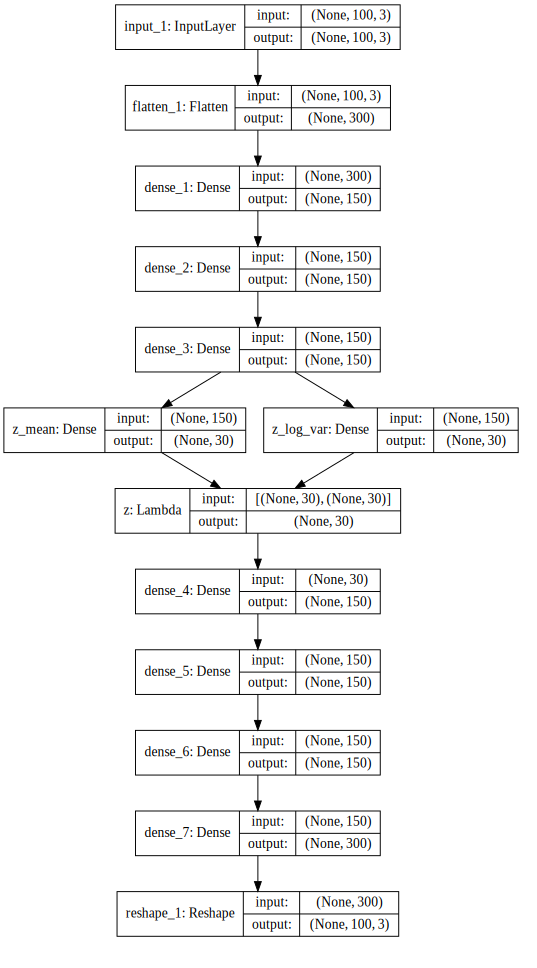

In [25]:
def VAE_FC_Z30():
    z_dim=30
    inp=Input(shape=(100,3))

    # Encoding
    x=Flatten()(inp)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    x=Dense(150, activation='relu')(z)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    y=Reshape((100, 3))(x)

    # Encoding
    #x= Reshape((100, 3, 1))(inp)
    #x= Conv2D(15, (10,1), strides=(10, 1), activation='relu')(x)
    #x= Conv2D(20, (2,1), strides=(2, 1), activation='relu')(x)
    #x= Conv2D(25, (4,1), activation='relu')(x)
    #x= Flatten()(x)
    #x=Dense(90, activation='relu')(x)
    #x=Dense(70, activation='relu')(x)
    #x=Dense(50, activation='relu')(x)
    #z_mean = Dense(z_dim, name='z_mean')(x)
    #z_log_var = Dense(z_dim, name='z_log_var')(x)
    #z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    #x=Dense(50, activation='relu')(z)
    #x=Dense(70, activation='relu')(x)
    #x=Dense(90, activation='relu')(x)
    #x=Dense(150, activation='relu')(x)
    #x= Reshape((2, 3, 25))(x)
    #x= Conv2DTranspose(20, (4,1), activation='relu')(x)
    #x= Conv2DTranspose(15, (2,1), strides=(2, 1), activation='relu')(x)
    #x= Conv2DTranspose(1, (10,1), strides=(10, 1))(x)
    #y= Reshape((100, 3))(x)
    
    # loss
    def reconstruction_loss(out_true, out_pred):
      return rmse(out_true, out_pred)
    def kl_loss(out_true, out_pred):
      return .1*kl(z_mean,z_log_var)
    def vae_loss(out_true, out_pred):      
      return reconstruction_loss(out_true, out_pred) + kl_loss(out_true, out_pred)

    # build model
    vae = Model(inputs=[inp], outputs=[y])
    #vae.add_loss(vae_loss)
    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reconstruction_loss,kl_loss])
    vae.summary()
    
    encoder = Model(inputs=[inp], outputs=[z_mean])
    return vae, encoder

vae,_=VAE_FC_Z30()
SVG(model_to_dot(vae, show_shapes='true', show_layer_names='true', dpi=70).create(prog='dot', format='svg'))

In [26]:
#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
#AE,E,train_data =AE_analysis(VAE_Z30, 10, x_train, x_test, filename='VAE_Z30')

train_data=vae.fit([x_train], [y_train], shuffle=True, epochs=500, batch_size=128, validation_data=([x_test], [y_test]), verbose=1)

Train on 16067 samples, validate on 4017 samples
Epoch 1/500
16067/16067 [==============================] - 3s 186us/step - loss: 24.6038 - reconstruction_loss: 22.6620 - kl_loss: 1.9418 - val_loss: 11.9451 - val_reconstruction_loss: 9.4266 - val_kl_loss: 2.5185
Epoch 2/500
16067/16067 [==============================] - 1s 70us/step - loss: 10.8004 - reconstruction_loss: 8.6526 - kl_loss: 2.1478 - val_loss: 10.2361 - val_reconstruction_loss: 8.4456 - val_kl_loss: 1.7906
Epoch 3/500
16067/16067 [==============================] - 1s 71us/step - loss: 9.8703 - reconstruction_loss: 8.2949 - kl_loss: 1.5754 - val_loss: 9.6139 - val_reconstruction_loss: 8.2324 - val_kl_loss: 1.3815
Epoch 4/500
16067/16067 [==============================] - 1s 70us/step - loss: 9.2937 - reconstruction_loss: 8.0208 - kl_loss: 1.2728 - val_loss: 8.8254 - val_reconstruction_loss: 7.6483 - val_kl_loss: 1.1771
Epoch 5/500
16067/16067 [==============================] - 1s 70us/step - loss: 7.5180 - reconstruction_l

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 3)       0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 300)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 150)          45150       flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 150)          22650       dense_1[0][0]                    
____________________________________________________________________________________________

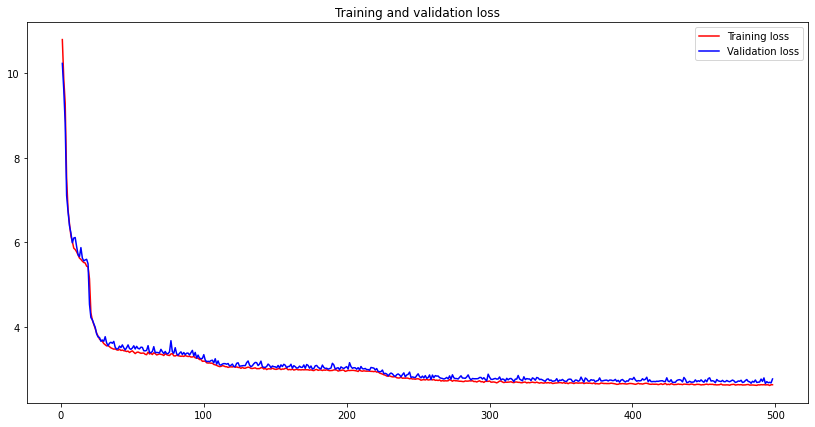

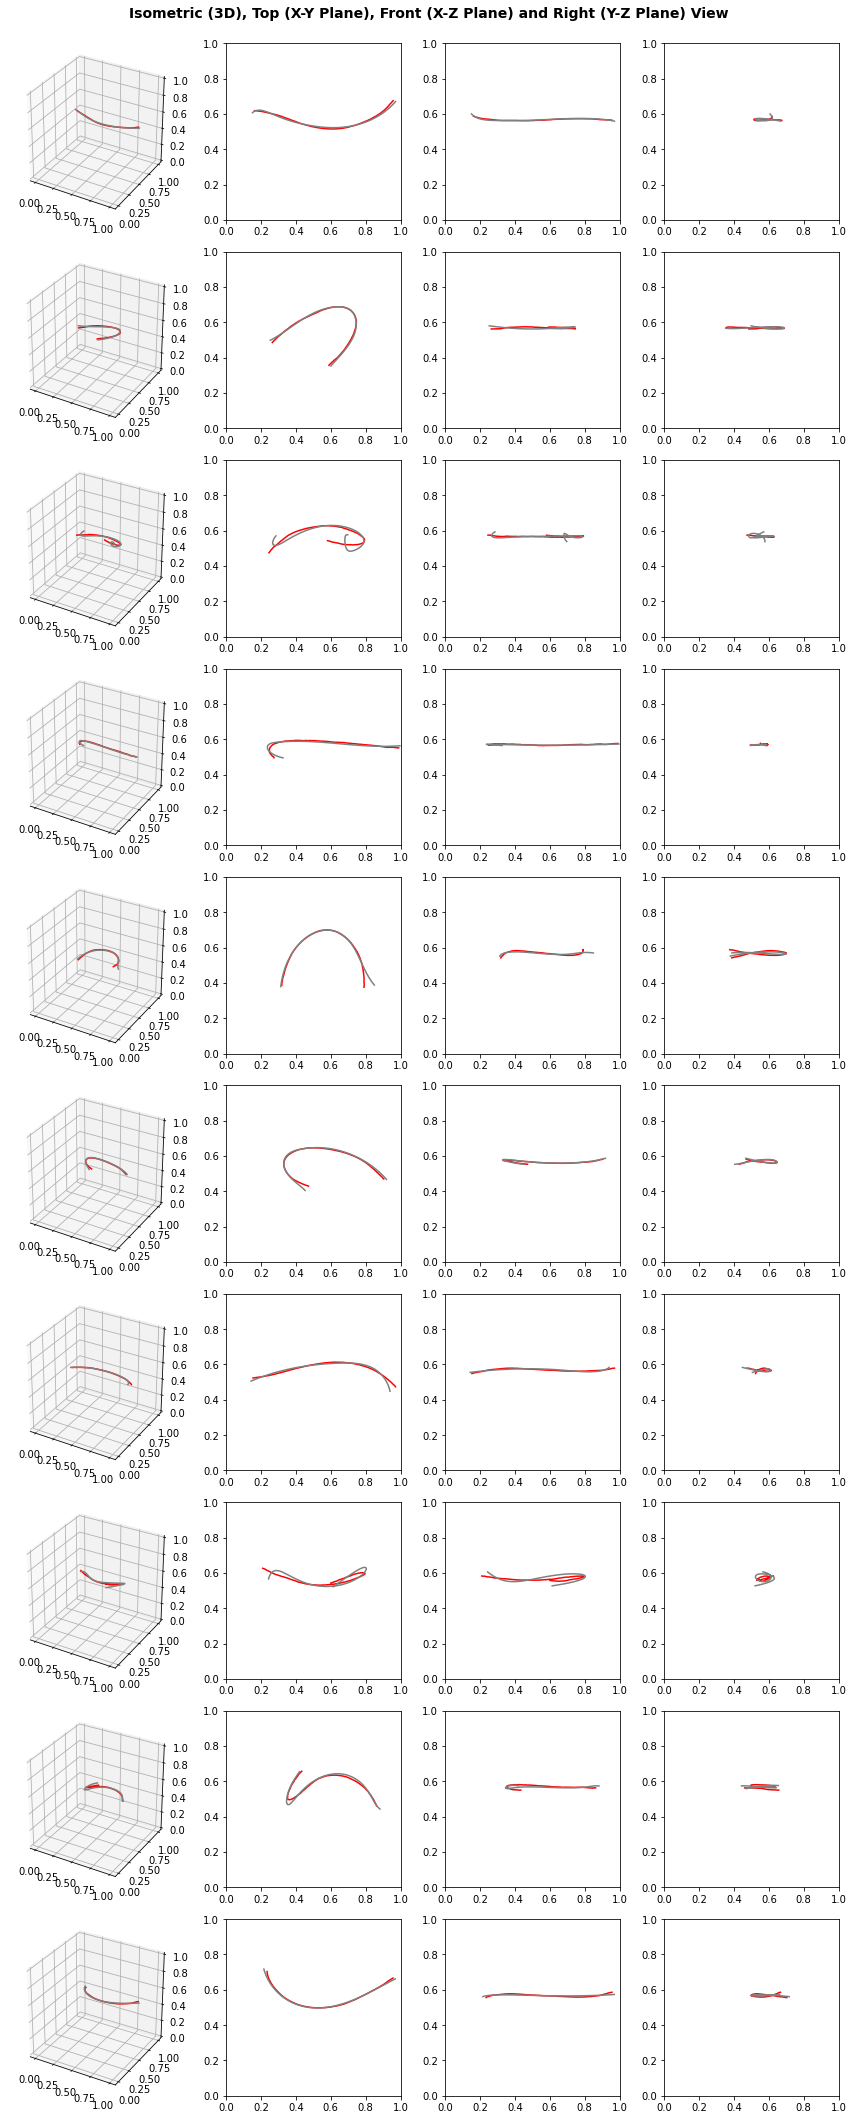

In [27]:
def visualize_train_curves(train_data):
    loss = train_data.history['loss']
    val_loss = train_data.history['val_loss']
    
    f_loss=np.round_(loss[-1],decimals=4)
    f_val_loss=np.round_(val_loss[-1],decimals=4)
    
    print('Training loss: '+str(f_loss))
    print('Validation loss: '+str(f_val_loss))
    
    epochsRange = range(len(loss))
    plt.figure(figsize=(14, 7))
    plt.plot(epochsRange[1:-1], loss[1:-1], 'r', label='Training loss')
    plt.plot(epochsRange[1:-1], val_loss[1:-1], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

visualize_AE(vae, train_data, x_test, y_test)

## Cov2D (Z=30)

In [1]:
def VAE_Cov2D_Z30():
    z_dim=30
    inp=Input(shape=(100,3))

    # Encoding
    x= Reshape((100, 3, 1))(inp)
    x= Conv2D(15, (10,1), strides=(10, 1), activation='relu')(x)
    x= Conv2D(20, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2D(25, (4,1), activation='relu')(x)
    x= Flatten()(x)
    x=Dense(90, activation='relu')(x)
    x=Dense(70, activation='relu')(x)
    x=Dense(50, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    x=Dense(50, activation='relu')(z)
    x=Dense(70, activation='relu')(x)
    x=Dense(90, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x= Reshape((2, 3, 25))(x)
    x= Conv2DTranspose(20, (4,1), activation='relu')(x)
    x= Conv2DTranspose(15, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2DTranspose(1, (10,1), strides=(10, 1))(x)
    y= Reshape((100, 3))(x)
    
    # loss
    def reconstruction_loss(out_true, out_pred):
      return rmse(out_true, out_pred)
    def kl_loss(out_true, out_pred):
      return .1*kl(z_mean,z_log_var)
    def vae_loss(out_true, out_pred):      
      return reconstruction_loss(out_true, out_pred) + kl_loss(out_true, out_pred)

    # build model
    vae = Model(inputs=[inp], outputs=[y])
    #vae.add_loss(vae_loss)
    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reconstruction_loss,kl_loss])
    vae.summary()
    
    encoder = Model(inputs=[inp], outputs=[z_mean])
    return vae, encoder

vae,_=VAE_Cov2D_Z30()
SVG(model_to_dot(vae, show_shapes='true', show_layer_names='true', dpi=70).create(prog='dot', format='svg'))

NameError: ignored

In [0]:
#resetRNG(0)
#x_train_3D=np.expand_dims(x_train, 4)
#x_test_3D=np.expand_dims(x_test, 4)
#AE,E,train_data =AE_analysis(VAE_Z30, 10, x_train, x_test, filename='VAE_Z30')

train_data=vae.fit([x_train], [y_train], shuffle=True, epochs=500, batch_size=128, validation_data=([x_test], [y_test]), verbose=1)

## Model Inference

In [0]:
# Import autoencoder for z-space representation
import os
import numpy as np
from keras.models import Model, load_model

# Load Autoencoder model with Z=30
filename='AE_D3_val_loss_0.0049.h5'
path=os.path.join('models',filename)
AE_Z3 = load_model(path, custom_objects={'rmse': rmse})
E_Z3 = Model(AE_Z3.input, AE_Z3.layers[5].output)
E_Z3.summary()

z_param= E_Z3.predict(cplr_true)
print(z_param.shape)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 3)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_26 (Dense)             (None, 150)               30150     
_________________________________________________________________
dense_27 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_28 (Dense)             (None, 30)                3030      
Total params: 108,480
Trainable params: 108,480
Non-trainable params: 0
_____________________________________________________

In [0]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=500)
labels=clustering.fit_predict(z_param)
print(labels.shape)

In [0]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=500)
kmeans.fit(z_param)
labels=kmeans.predict(z_param)
centers = kmeans.cluster_centers_

Random index selected =  22


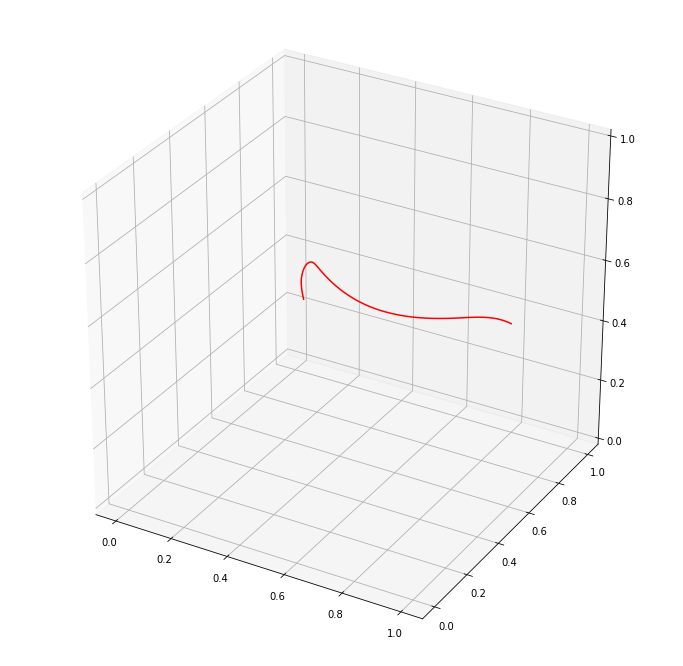

In [0]:
#Select an arbitrary path
n=random.randint(0, z_param.shape[0])
n=22 #22,49
print("Random index selected = ",n)
fig= plt.figure(figsize=(12, 12))
ax = plt.subplot(1, 1, 1, projection='3d')
plotPath3D(n_cplr_true[n], ax, 1,'r' )

In [0]:
current_dir=os.getcwd()
db_path=os.path.join(current_dir,'..','1. DB Preprocessing','db4_5SS_mirror_s20084.npz')
db = np.load(db_path)
print(db.files)
mech=db['mechData']
print(mech.shape)
# Renormalize DB from range [-1,1] to range [0,1] 
n_mech=mech/(np.abs(data_min)+data_max)+np.abs(data_min)

['cplrData', 'mechData']
(20084, 11, 3)


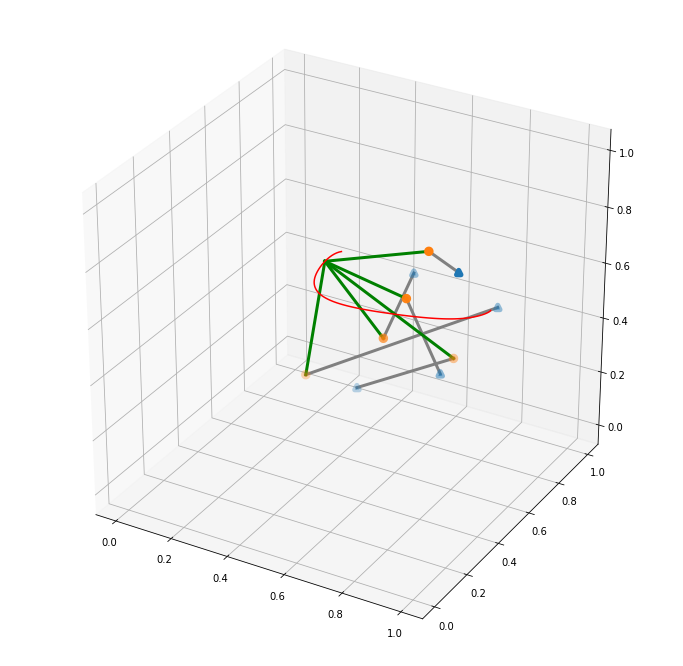

In [0]:
def plotLine3D(P1,P2,ax,color):
  ax.plot3D([P1[0],P2[0]], [P1[1],P2[1]], [P1[2],P2[2]],linewidth=3, color=color)

def plotMech5SS(mech,ax):
    Fp1=mech[0]; Fp2=mech[1];Fp3=mech[2]; Fp4=mech[3];Fp5=mech[4];
    Mp1=mech[5]; Mp2=mech[6];Mp3=mech[7]; Mp4=mech[8];Mp5=mech[9];
    C=mech[10];

    c1='grey'
    c2='g'
    plotLine3D(Fp1,Mp1,ax,c1)
    plotLine3D(Fp2,Mp2,ax,c1)
    plotLine3D(Fp3,Mp3,ax,c1)
    plotLine3D(Fp4,Mp4,ax,c1)
    plotLine3D(Fp5,Mp5,ax,c1)
    
    plotLine3D(Mp1,C,ax,c2)
    plotLine3D(Mp2,C,ax,c2)
    plotLine3D(Mp3,C,ax,c2)
    plotLine3D(Mp4,C,ax,c2)
    plotLine3D(Mp5,C,ax,c2)

    ax.scatter3D(mech[0:5,0],mech[0:5,1],mech[0:5,2],marker='^',linewidths=5)
    ax.scatter3D(mech[5:10,0],mech[5:10,1],mech[5:10,2],marker='o',linewidths=5)

i=7
fig= plt.figure(figsize=(12, 12))
ax = plt.subplot(1, 1, 1, projection='3d')
plotMech5SS(n_mech[i],ax)
plotPath3D(n_cplr_true[i], ax, 1,'r' )

91


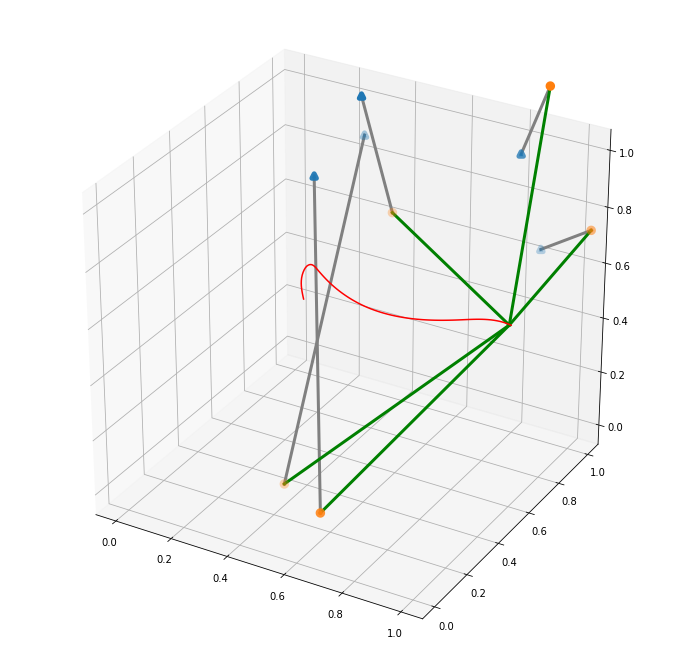

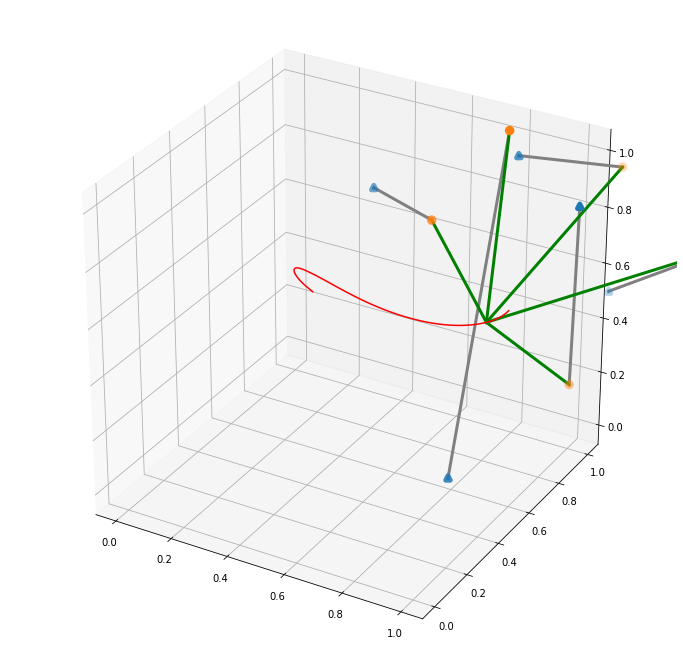

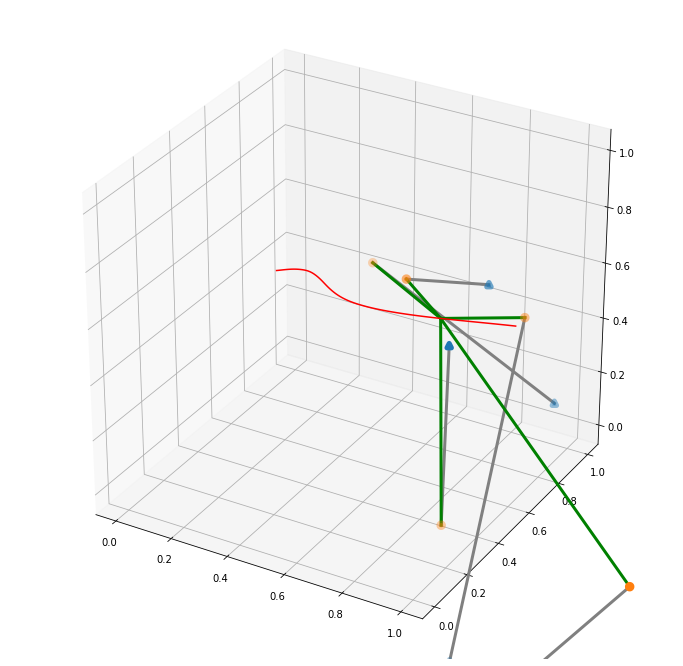

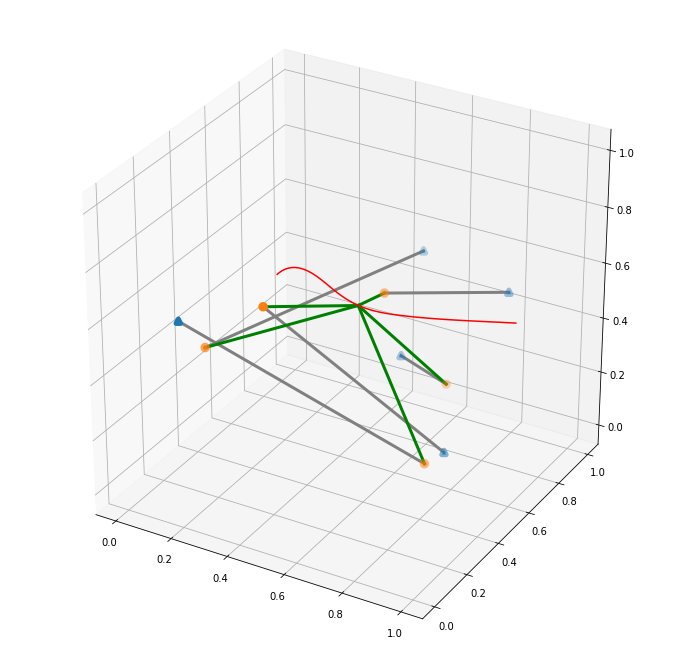

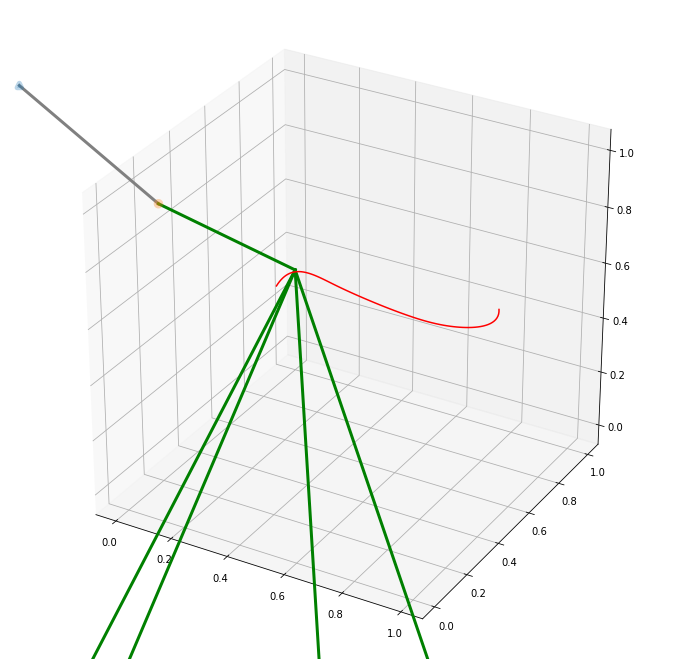

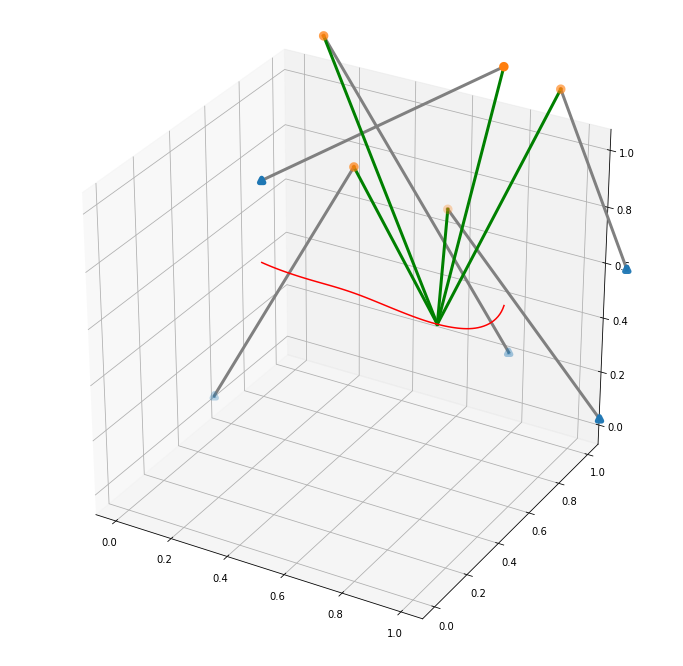

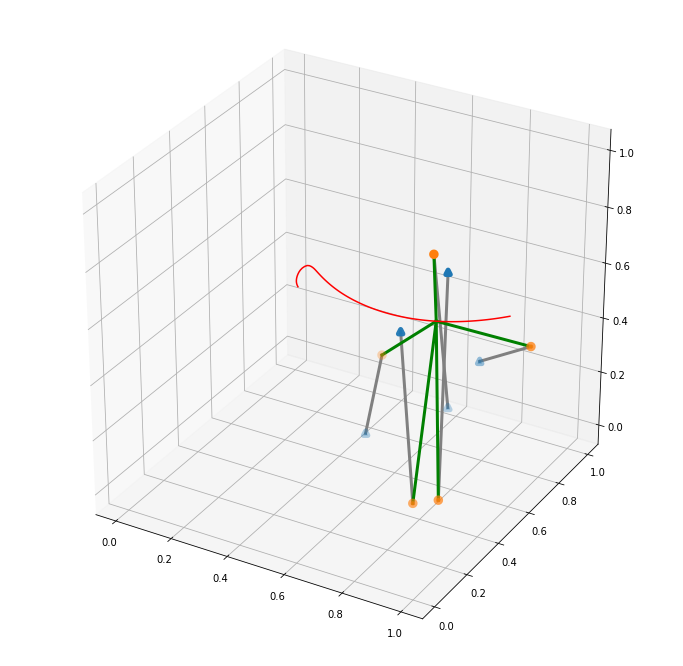

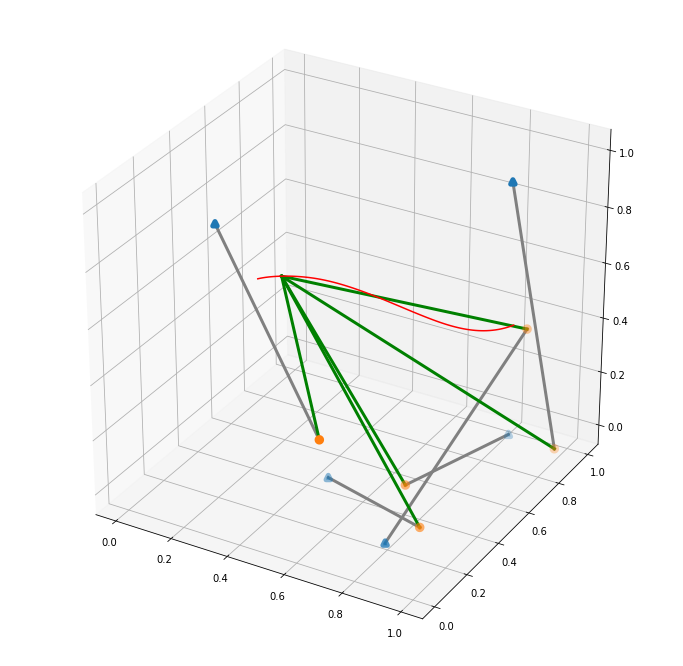

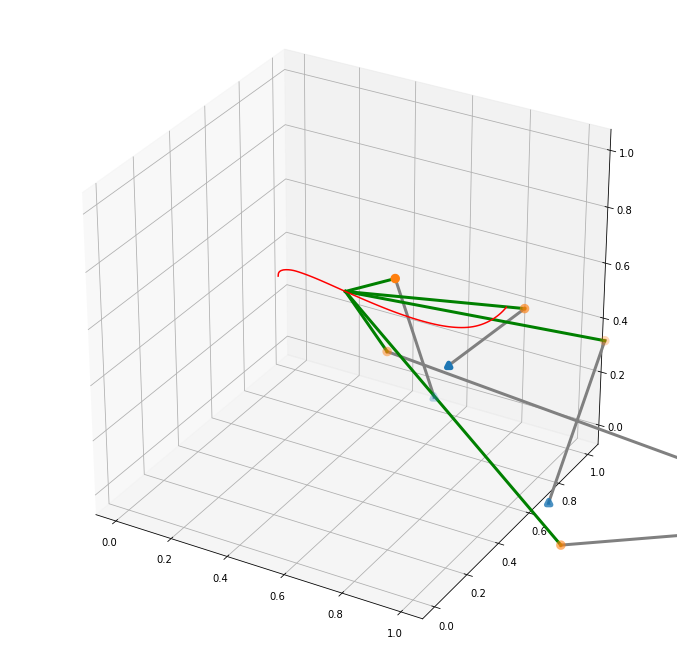

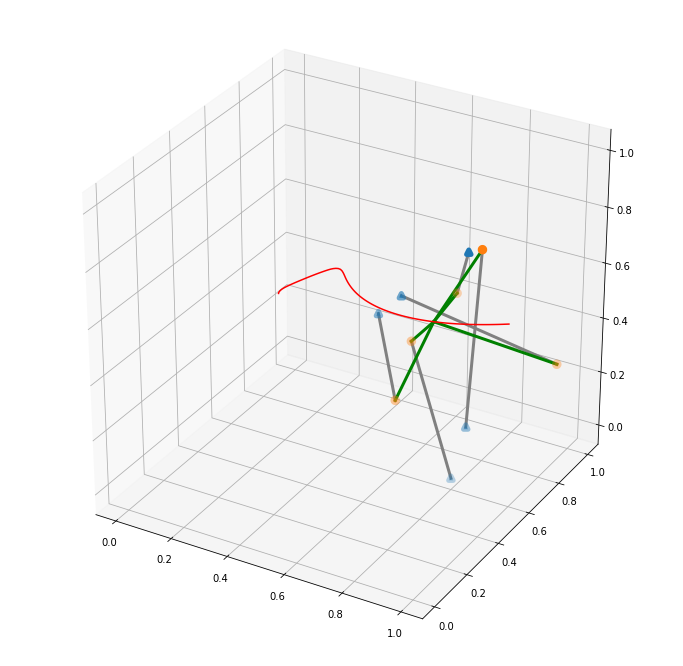

In [0]:
z_user=z_param[n]
minDist=99999999
group_id=-1
for i in range(500):
  d=np.linalg.norm(z_user-centers[i])
  if d<minDist:
    minDist=d
    group_id=i

sol=[]
for i in range(0,z_param.shape[0]):
  if labels[i]==group_id:
    sol.append(i)

for i in range(10):
    fig= plt.figure(figsize=(12, 12))
    ax = plt.subplot(1, 1, 1, projection='3d')
    plotMech5SS(n_mech[sol[i]],ax)
    plotPath3D(n_cplr_true[sol[i]], ax, 1,'r' )
    
print(len(sol))

# Conditional Variational Autoencoder (CVAE)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 100, 3)       0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 100, 1)       0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 100, 4)       0           input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
reshape_23 (Reshape)            (None, 100, 4, 1)    0           concatenate_13[0][0]      

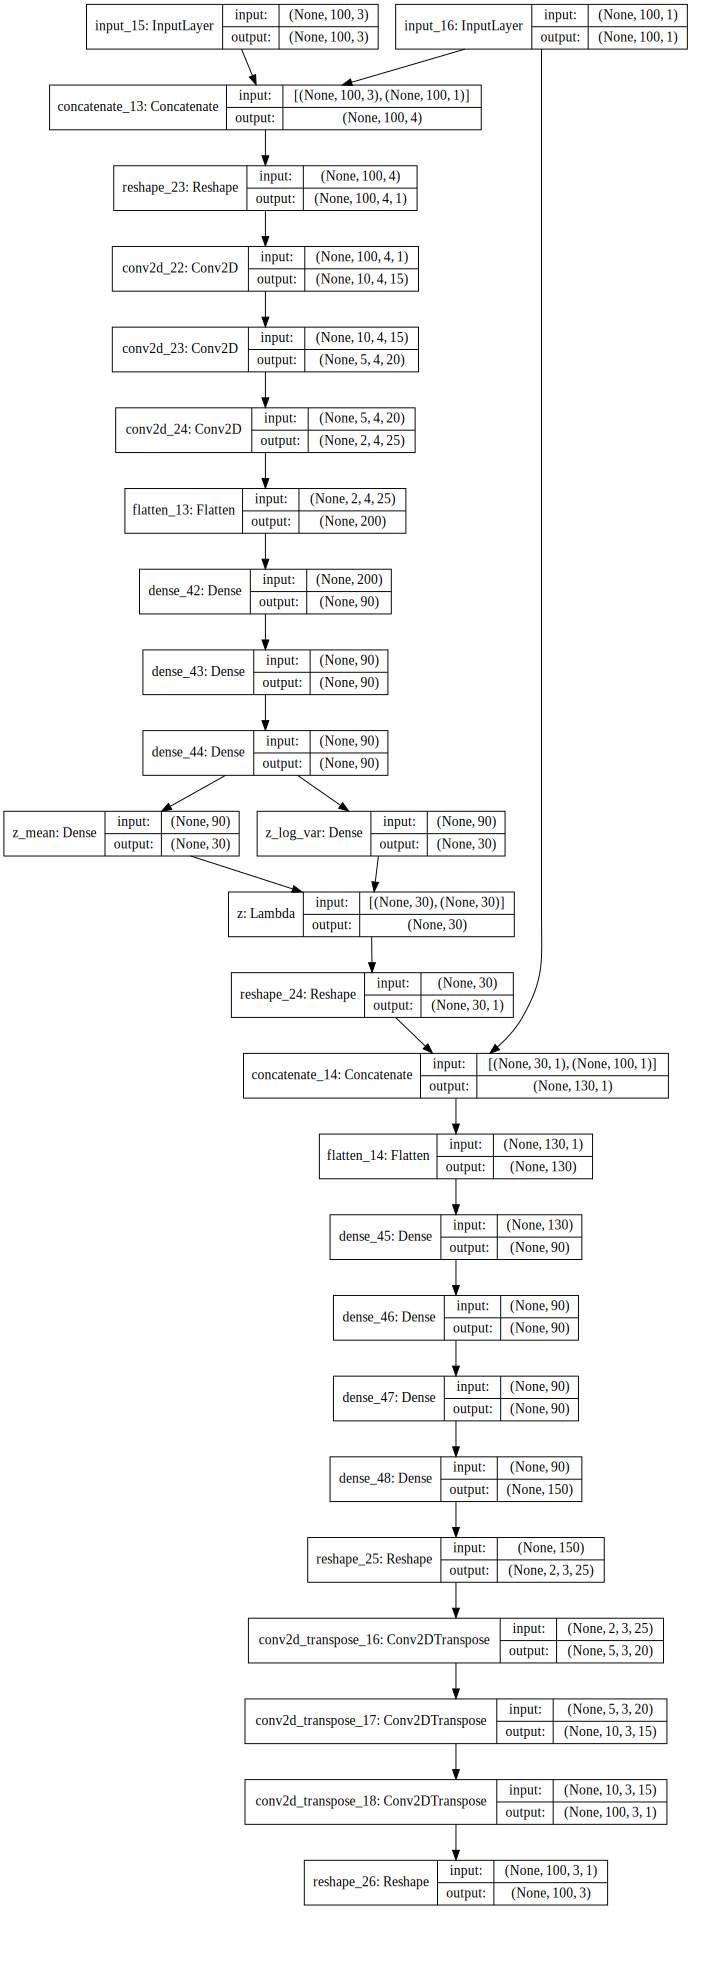

In [0]:
# Conditional VAE
# for path completion
# Train using mask and respective incomplete paths as input and full path as output.
def CVAE_Z30():
    z_dim=30
    inp=Input(shape=(100,3))
    condition=Input(shape=(100,1))

    # Encoding
    inp_cond= Concatenate()([inp, condition])
    x= Reshape((100, 4, 1))(inp_cond)
    x= Conv2D(15, (10,1), strides=(10, 1), activation='relu')(x)
    x= Conv2D(20, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2D(25, (4,1), activation='relu')(x)
    x= Flatten()(x)
    x=Dense(90, activation='relu')(x)
    x=Dense(70, activation='relu')(x)
    x=Dense(50, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

    # Decoding
    z = Reshape((z_dim, 1))(z)
    z_cond = Concatenate(axis=-2)([z, condition])
    x=Flatten()(z_cond)
    x=Dense(50, activation='relu')(x)
    x=Dense(70, activation='relu')(x)
    x=Dense(90, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x= Reshape((2, 3, 25))(x)
    x= Conv2DTranspose(20, (4,1), activation='relu')(x)
    x= Conv2DTranspose(15, (2,1), strides=(2, 1), activation='relu')(x)
    x= Conv2DTranspose(1, (10,1), strides=(10, 1))(x)
    y= Reshape((100, 3))(x)
    
    # loss
    def reconstruction_loss(out_true, out_pred):
      return rmse(out_true, out_pred)
    def kl_loss(out_true, out_pred):
      return .1*kl(z_mean,z_log_var)
    def vae_loss(out_true, out_pred):   
      return reconstruction_loss(out_true, out_pred) + kl_loss(out_true, out_pred)

    # build model
    cvae = Model(inputs=[inp,condition], outputs=[y])
    #cvae.add_loss(vae_loss)
    cvae.compile(optimizer='adam', loss=vae_loss, metrics=[reconstruction_loss,kl_loss])
    cvae.summary()
    
    encoder = Model(inputs=[inp,condition], outputs=[z_mean])
    return cvae, encoder

cvae,_=CVAE_Z30()
SVG(model_to_dot(cvae, show_shapes='true', show_layer_names='true', dpi=70).create(prog='dot', format='svg'))

In [0]:
current_dir=os.getcwd()
db_path=os.path.join(current_dir,'..','1. DB Preprocessing','db6_5SS_noisy_s60252.npz')
db = np.load(db_path)
cplr_noisy=db['cplrData']
cplr_mask=np.expand_dims(db['cplrMask'], axis=-1)
print(cplr_noisy.shape)
print(cplr_mask.shape)

cplr_mir = import_DB('db4_5SS_mirror_s20084.npz')
db_part=[]
n_partial=2
for i in range(cplr_mir.shape[0]):
  for j in range(n_partial):
    db_part.append(cplr_mir[i])
cplr_true=np.append(cplr_mir,np.array(db_part),axis=0)
print(cplr_true.shape)

(60252, 100, 3)
(60252, 100, 1)
(60252, 100, 3)


In [0]:
data_max=np.max([np.max(cplr_noisy),np.max(cplr_true)])
data_min=np.min([np.min(cplr_noisy),np.min(cplr_true)])
print(data_max)
print(np.abs(data_min))

0.5583904768264918
0.5764223109354129


In [0]:
# Renormalize DB from range [-1,1] to range [0,1] 
n_cplr_true=cplr_true/(np.abs(data_min)+data_max)+np.abs(data_min)
n_cplr_noisy=cplr_noisy/(np.abs(data_min)+data_max)+np.abs(data_min)

In [0]:
x= n_cplr_noisy
y= n_cplr_true
mask=cplr_mask

# Split data into training and testing dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, m_train, m_test = train_test_split(x, y, mask, test_size=0.2, random_state=1)

print(x_train.shape)
print(y_train.shape)
print(m_train.shape)
print(x_test.shape)
print(y_test.shape)
print(m_test.shape)

(48201, 100, 3)
(48201, 100, 3)
(48201, 100, 1)
(12051, 100, 3)
(12051, 100, 3)
(12051, 100, 1)


In [0]:
train_data=cvae.fit([x_train,m_train], [y_train], shuffle=True, epochs=50, batch_size=128, validation_data=([x_test,m_test], [y_test]), verbose=1)

Train on 48201 samples, validate on 12051 samples
Epoch 1/50
48201/48201 [==============================] - 4s 91us/step - loss: 3.3432 - reconstruction_loss: 2.7580 - kl_loss: 0.5852 - val_loss: 3.4118 - val_reconstruction_loss: 2.8286 - val_kl_loss: 0.5833
Epoch 2/50
48201/48201 [==============================] - 4s 93us/step - loss: 3.3256 - reconstruction_loss: 2.7375 - kl_loss: 0.5881 - val_loss: 3.3651 - val_reconstruction_loss: 2.7731 - val_kl_loss: 0.5920
Epoch 3/50
48201/48201 [==============================] - 5s 111us/step - loss: 3.3255 - reconstruction_loss: 2.7383 - kl_loss: 0.5872 - val_loss: 3.4466 - val_reconstruction_loss: 2.8622 - val_kl_loss: 0.5843
Epoch 4/50
48201/48201 [==============================] - 5s 103us/step - loss: 3.3240 - reconstruction_loss: 2.7368 - kl_loss: 0.5872 - val_loss: 3.3826 - val_reconstruction_loss: 2.7867 - val_kl_loss: 0.5959
Epoch 5/50
48201/48201 [==============================] - 5s 99us/step - loss: 3.3093 - reconstruction_loss: 2.7

Training loss: 3.2138
Validation loss: 3.3216


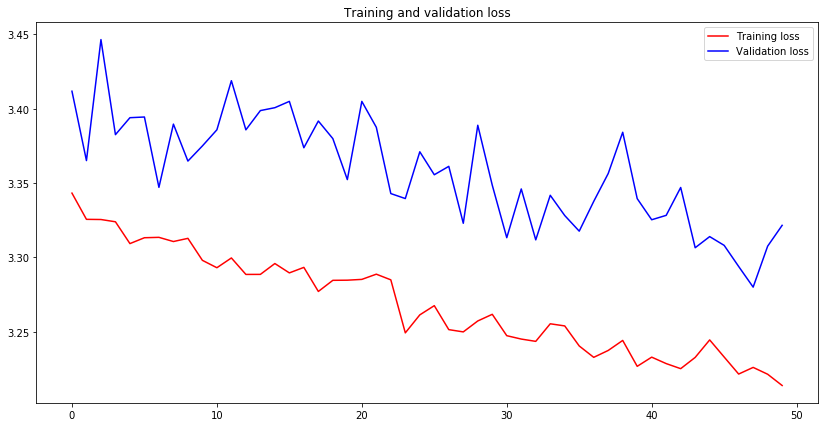

In [0]:
visualize_train_curves(train_data)

In [0]:
%matplotlib inline
#%matplotlib notebook

import numpy as np 
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from numpy import linalg as LA
#plt.style.use('dark_background')


def plotPath3D(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline, yline, zline, color)
    ax.auto_scale_xyz([-limit, limit], [-limit, limit], [-limit, limit])
    plt.tight_layout()

def plotPath(Pts, ax, limit, color = 'gray'):
    xline=Pts[:,0]
    yline=Pts[:,1]
    ax.plot(xline, yline, color)
    ax.set(xlim=(0, limit), ylim=(0, limit))

def plotXYZ(center, RotMat, ax):
    C=np.vstack((center,center,center))
    R=RotMat
    r=(1,0,0)
    g=(0,1,0)
    b=(0,0,1)
    ax.quiver(C[:,0], C[:,1], C[:,2], R[:,0], R[:,1], R[:,2],color=(r,g,b,r,r,g,g,b,b))
    plt.tight_layout()


def visualizePaths(Paths,rows=10,cols=3, axlimit=.5):
    path_index=0;
    fig = plt.figure(figsize=2*plt.figaspect(rows/cols))
    for i in range(rows):
        for j in range(cols):
            Pts=Paths[path_index]
            path_index=path_index+1
            ax = fig.add_subplot(rows, cols, path_index, projection='3d')
            plotPath(Pts, ax, axlimit)
            #plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
    plt.tight_layout()
    plt.show()

def visualizePathsRand(Paths,rows=10,cols=3, axlimit=.5):
    path_index=0;
    fig = plt.figure(figsize=2*plt.figaspect(rows/cols))
    for i in range(rows):
        for j in range(cols):
            Pts=Paths[np.random.randint(Paths.shape[0])]
            path_index=path_index+1
            ax = fig.add_subplot(rows, cols, path_index, projection='3d')
            plotPath(Pts, ax, axlimit)
            #plotXYZ(np.zeros((1, 3)), np.identity(3), ax)
    plt.tight_layout()
    plt.show()

In [0]:
reconst_curve = cvae.predict([x_train,m_train])

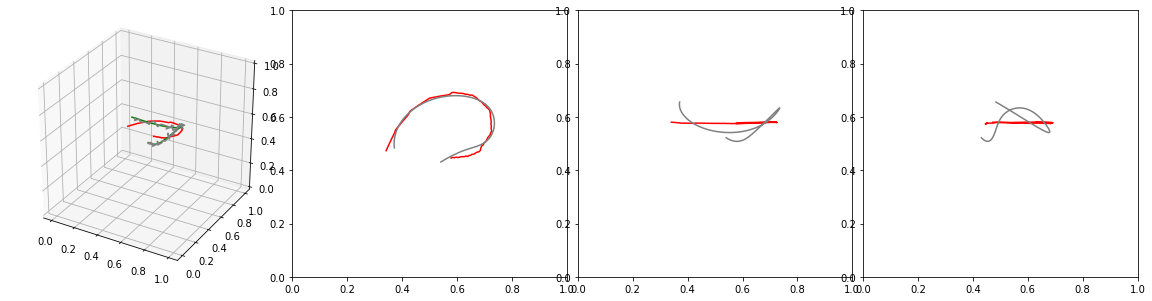

In [0]:
def plotPartialPath(Pts, mask, ax, limit, color = 'gray'):
    ind=np.nonzero(mask)
    xline=Pts[:,0]
    yline=Pts[:,1]
    zline=Pts[:,2]
    ax.plot3D(xline[ind[0]], yline[ind[0]], zline[ind[0]], color)
    ax.auto_scale_xyz([0, limit], [0, limit], [0, limit])
    plt.tight_layout()


i=4
orig=y_train[i]
recon=reconst_curve[i]

fig= plt.figure(figsize=(16, 4))
ax = plt.subplot(1, 4, 1, projection='3d')
#3D view
plotPath3D(reconst_curve[i],ax,1,'r')
plotPath3D(y_train[i],ax,1,'g')
plotPartialPath(x_train[i],m_train[i],ax,1)

#x-y, x-z, y-z plane view
xy_recon=recon[:,0:2]
xy_orig=orig[:,0:2]
xz_recon=np.concatenate(([recon[:,0]], [recon[:,2]]),axis=0).T
xz_orig=np.concatenate(([orig[:,0]], [orig[:,2]]),axis=0).T
yz_recon=recon[:,1:3]
yz_orig=orig[:,1:3]

# Top View
ax = plt.subplot(1, 4, 2)
plotPath(xy_recon, ax, 1,'r' )
plotPath(xy_orig, ax, 1)
    
# Front View
ax = plt.subplot(1, 4, 3)
plotPath(xz_recon, ax, 1,'r' )
plotPath(xz_orig, ax, 1)
       
# Right View
ax = plt.subplot(1, 4, 4)
plotPath(yz_recon, ax, 1,'r' )
plotPath(yz_orig, ax, 1)

plt.show()

# Shared-encoder CVAE

In [0]:
# Shared Encoder CVAE
# Has single encoder and multiple decoders
# Used to generate DeepFake/FaceSwap

def SE_CVAE_encoder():
    z_dim=30
    inp=Input(shape=(100,3))
    condition=Input(shape=(100,1))

    # Encoding
    inp_cond= Concatenate()([inp, condition])
    x=Flatten()(inp_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    z_mean = Dense(z_dim, name='z_mean')(x)
    z_log_var = Dense(z_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])
    z = Reshape((z_dim, 1))(z)
    
    return Model(inputs=[inp,condition], outputs=[z,z_mean,z_log_var])
    
def SE_CVAE_decoder():
    z_dim=30
    z=Input(shape=(z_dim,1))
    condition=Input(shape=(100,1))

    # Encoding
    z_cond = Concatenate(axis=-2)([z, condition])
    x=Flatten()(z_cond)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(150, activation='relu')(x)
    x=Dense(300)(x)
    y=Reshape((100, 3))(x)
    
    return Model(inputs=[z,condition], outputs=[y])

def SE_CVAE():
    encoder = SE_CVAE_encoder()
    decoder_A = SE_CVAE_decoder()
    decoder_B = SE_CVAE_decoder()
    
    x = Input(shape=(100,3))
    m = Input(shape=(100,1))
    y1= decoder_A([encoder([x,m])[0],m])
    y2= decoder_B([encoder([x,m])[0],m])
    z_mean= encoder([x,m])[1]
    z_log_var= encoder([x,m])[2]
    print(z_mean)
    
    # loss
    reconstruction_loss1 = mse(x, y1)
    reconstruction_loss2 = mse(x, y2)
    kl_loss = 0.5 * K.sum(K.square(z_mean) + K.exp(z_log_var) - z_log_var - 1, axis = -1)
    vae_loss1 = reconstruction_loss1 + kl_loss
    vae_loss2 = reconstruction_loss2 + kl_loss    

    # build model
    SE_CVAE_1 = Model(inputs=[x,m], outputs=[y1])
    SE_CVAE_2 = Model(inputs=[x,m], outputs=[y2])
    SE_CVAE_1.add_loss(vae_loss1)
    SE_CVAE_2.add_loss(vae_loss2)
    
    SE_CVAE_1.compile(optimizer='adam')
    SE_CVAE_2.compile(optimizer='adam')
    SE_CVAE_1.summary()
    SE_CVAE_2.summary()
    
    return SE_CVAE_1, SE_CVAE_2, encoder

SE_CVAE_1,SE_CVAE_2,_=SE_CVAE()

Tensor("model_125/z_mean/BiasAdd:0", shape=(?, 30), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_290 (InputLayer)          (None, 100, 3)       0                                            
__________________________________________________________________________________________________
input_291 (InputLayer)          (None, 100, 1)       0                                            
__________________________________________________________________________________________________
model_125 (Model)               [(None, 30, 1), (Non 114510      input_290[0][0]                  
                                                                 input_291[0][0]                  
__________________________________________________________________________________________________
model_126 (Model)               (None, 100

In [0]:
pbar = tqdm(range(100))
for epoch in pbar:
    autoencoder_A.fit(first_training, first_classes, batch_size=32, nb_epoch=1)
    autoencoder_B.fit(first_training, first_classes, batch_size=32, nb_epoch=1)
    #loss_A = autoencoder_A.train_on_batch([warped_A,mask_A], [target_A,mask_A])
    #loss_B = autoencoder_B.train_on_batch([warped_B,mask_B], [target_B,mask_B])
    #pbar.set_description("Loss A [{}] Loss B [{}]".format(loss_A,loss_B))
    #Track best model
    
    

NameError: name 'tqdm' is not defined

In [0]:
# Disentangling VAE

In [0]:
# Deep feature consistent variational auto-encoder
# using 'feature perceptual loss' instead of 'reconstruction loss'
# needs a pre-trained 'perception model'

In [0]:
# use domain knowledge and use multiple parallel input lambda layers for FDs, CAD, wavelets, etc